# Siamse network
---------------------------------------
2つのMatrixを引数に取るような任意の類似度関数を学習するNNを作成してみる．

In [1]:
import os
import sys
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
sys.path.append("../spykesim")
import editsim
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
ops.reset_default_graph()

In [2]:
sess = tf.Session()

In [3]:
n_train, n_test = 1000, 100
size = 10
min_, max_ = 0, 2
nrow = 10
ncol = 10

def gen_data(min_, max_, size):
    return np.random.randint(
        min_, max_, nrow*ncol).reshape(nrow, ncol)
X_train_ = np.array([
    [gen_data(min_, max_, size), gen_data(min_, max_, size)] for _ in range(n_train)
])
X_test_ = np.array([
    [gen_data(min_, max_, size), gen_data(min_, max_, size)] for _ in range(n_test)
])
# def sim1(x, y):
#     vec = np.zeros(x.shape[1])
#     for col in range(1, x.shape[1]):
#         vec[col] = np.dot(x[:, col] + x[:, col-1],  y[:, col] + y[:, col-1])
#     return vec.mean()
Y_train_ = np.array([
    editsim.clocal_exp_editsim(xs[0].astype(np.double), xs[1].astype(np.double))[0] for xs in X_train_
])
Y_test_ = np.array([
    editsim.clocal_exp_editsim(xs[0].astype(np.double), xs[1].astype(np.double))[0] for xs in X_test_
])

In [5]:
xt_mean = np.mean(X_train_)
xt_std = np.std(X_train_)
yt_mean = np.mean(Y_train_)
yt_std = np.std(Y_train_)

X_train = (X_train_ - xt_mean) / xt_std
X_test =  (X_test_ - xt_mean) / xt_std
Y_train = (Y_train_ - yt_mean) / yt_std
Y_test =  (Y_test_ - yt_mean) / yt_std
# Y_train = Y_train_
# Y_test = Y_test_

In [7]:
mat1_ph = tf.placeholder(tf.float32, [None, nrow, ncol], name="mat1_ph")
mat2_ph = tf.placeholder(tf.float32, [None, nrow, ncol], name="mat2_ph")

y_target_ph = tf.placeholder(tf.float32, [None], name="y_target_ph")
dropout_keep_prob_ph = tf.placeholder(tf.float32, name="dropout_keep_prob")

In [8]:
def get_batch(n, ntrain = n_train):
    sample_indices = [random.randint(0, n_train-1) for i in range(n)]
    return [[x, y] for x, y in zip(X_train[sample_indices], Y_train[sample_indices])]

In [9]:
def snn(address1, address2, dropout_keep_prob,
        vocab_size, num_features, input_length):
    
    # Define the siamese double RNN with a fully connected layer at the end
    def siamese_nn(input_vector, num_hidden):
        cell_unit = tf.contrib.rnn.BasicLSTMCell#tf.nn.rnn_cell.BasicLSTMCell
        
        # Forward direction cell
        lstm_forward_cell = cell_unit(num_hidden, forget_bias=1.0)
        lstm_forward_cell = tf.contrib.rnn.DropoutWrapper(lstm_forward_cell, output_keep_prob=dropout_keep_prob)
        
        # Backward direction cell
        lstm_backward_cell = cell_unit(num_hidden, forget_bias=1.0)
        lstm_backward_cell = tf.contrib.rnn.DropoutWrapper(lstm_backward_cell, output_keep_prob=dropout_keep_prob)
    
        # Split title into a character sequence
        input_embed_split = tf.split(axis=1, num_or_size_splits=input_length, value=input_vector)
        input_embed_split = [tf.squeeze(x, axis=[1]) for x in input_embed_split]
        
        # Create bidirectional layer
        #try:
        outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm_forward_cell,
                                                                lstm_backward_cell,
                                                                input_embed_split,                           
                                                                dtype=tf.float32)
        # except Exception:
        #    outputs = tf.contrib.rnn.static_bidirectional_rnn(lstm_forward_cell,
        #                                                      lstm_backward_cell,
        #                                                      input_embed_split,
        #                                                      dtype=tf.float32)
        # Average The output over the sequence
        temporal_mean = tf.add_n(outputs) / input_length
        
        # Fully connected layer
        output_size = 10
        A = tf.get_variable(name="A", shape=[2*num_hidden, output_size],
                            dtype=tf.float32,
                            initializer=tf.random_normal_initializer(stddev=0.1))
        b = tf.get_variable(name="b", shape=[output_size], dtype=tf.float32,
                            initializer=tf.random_normal_initializer(stddev=0.1))
        
        final_output = tf.matmul(temporal_mean, A) + b
        final_output = tf.nn.dropout(final_output, dropout_keep_prob)
        
        return(final_output)
        
    output1 = siamese_nn(address1, num_features)
    # Declare that we will use the same variables on the second string
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        output2 = siamese_nn(address2, num_features)
    
    # Unit normalize the outputs
    output1 = tf.nn.l2_normalize(output1, 1)
    output2 = tf.nn.l2_normalize(output2, 1)
    # Return cosine distance
    #   in this case, the dot product of the norms is the same.
    dot_prod = tf.reduce_sum(tf.multiply(output1, output2), 1)
    
    return(dot_prod)

In [10]:
def get_predictions(scores):
    # predictions = tf.sign(scores, name="predictions")
    return(scores)


def loss(scores, y_target, margin):
    # Average loss over batch
    loss = tf.reduce_mean(tf.square(tf.subtract(scores, y_target)))
    return(loss)


def accuracy(scores, y_target):
    predictions = get_predictions(scores)
    # Cast into integers (outputs can only be -1 or +1)
    y_target_int = tf.cast(y_target, tf.int32)
    # Change targets from (0,1) --> (-1, 1)
    #    via (2 * x - 1)
    #y_target_int = tf.sub(tf.mul(y_target_int, 2), 1)
    predictions_int = tf.cast(tf.sign(predictions), tf.int32)
    correct_predictions = tf.equal(predictions_int, y_target_int)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return(accuracy)

In [11]:
batch_size = 100     # How many addresses to train on in one batch
n_batches = 1000      # How many batches to train on
max_address_len = ncol # How many character to crop/pad each address
margin = 0.25        # A sort of regularization parameter that allows for 'wiggle' room in bad predicted similarities.
num_features = 100  # RNN feature size
dropout_keep_prob = 0.8 # Dropout probability

In [12]:
text_snn = snn(mat1_ph, mat2_ph, dropout_keep_prob_ph,
                 nrow, num_features, max_address_len)

In [13]:
# Define Accuracy
batch_accuracy = accuracy(text_snn, y_target_ph)
# Define Loss
batch_loss = loss(text_snn, y_target_ph, margin)
# Define Predictions
predictions = get_predictions(text_snn)

In [14]:
# Declare optimizer
optimizer = tf.train.AdamOptimizer(0.01)
# Apply gradients
train_op = optimizer.minimize(batch_loss)

# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [15]:
# Train loop
train_loss_vec = []
train_acc_vec = []
for b in range(n_batches):
    # Get a batch of data
    batch_data = get_batch(batch_size)
    # Shuffle data
    np.random.shuffle(batch_data)
    # Parse addresses and targets
    input_addresses = [x[0] for x in batch_data]
    target_similarity = np.array([x[1] for x in batch_data])
    address1 = np.array([x[0] for x in input_addresses])
    address2 = np.array([x[1] for x in input_addresses])
    
    train_feed_dict = {mat1_ph: address1,
                       mat2_ph: address2,
                       y_target_ph: target_similarity,
                       dropout_keep_prob_ph: dropout_keep_prob}

    _, train_loss, train_acc = sess.run([train_op, batch_loss, batch_accuracy],
                                        feed_dict=train_feed_dict)
    # Save train loss and accuracy
    train_loss_vec.append(train_loss)
    train_acc_vec.append(train_acc)
    # Print out statistics
    if b%100==0:
        print('Training Metrics, Batch {0}: Loss={1:.3f}, Accuracy={2:.3f}.'.format(b, train_loss, train_acc))

Training Metrics, Batch 0: Loss=1.232, Accuracy=0.170.
Training Metrics, Batch 100: Loss=0.526, Accuracy=0.180.
Training Metrics, Batch 200: Loss=0.327, Accuracy=0.240.
Training Metrics, Batch 300: Loss=0.311, Accuracy=0.180.
Training Metrics, Batch 400: Loss=0.223, Accuracy=0.210.
Training Metrics, Batch 500: Loss=0.316, Accuracy=0.190.
Training Metrics, Batch 600: Loss=0.314, Accuracy=0.210.
Training Metrics, Batch 700: Loss=0.307, Accuracy=0.300.
Training Metrics, Batch 800: Loss=0.350, Accuracy=0.210.
Training Metrics, Batch 900: Loss=0.331, Accuracy=0.150.


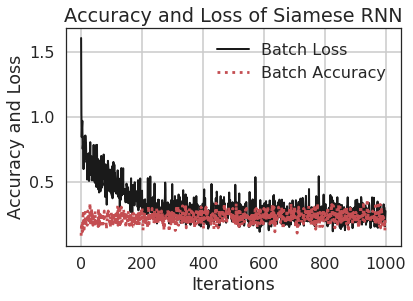

In [25]:
# Plot the loss and accuracy
%matplotlib inline
plt.plot(train_loss_vec, 'k-', lw=2, label='Batch Loss')
plt.plot(train_acc_vec, 'r:', label='Batch Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy and Loss')
plt.title('Accuracy and Loss of Siamese RNN')
plt.grid()
plt.legend()
plt.show()

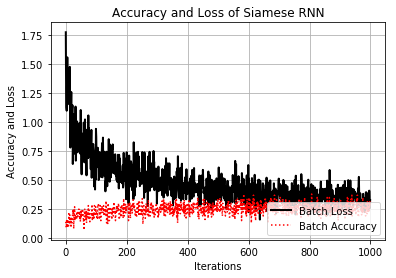

In [16]:
# Plot the loss and accuracy
%matplotlib inline
plt.plot(train_loss_vec, 'k-', lw=2, label='Batch Loss')
plt.plot(train_acc_vec, 'r:', label='Batch Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy and Loss')
plt.title('Accuracy and Loss of Siamese RNN')
plt.grid()
plt.legend(loc='lower right')
plt.show()